# Vehicle Detection & Tracking

The task in this project is to detect and track vehicles in images and videos.

To do this, we have to decide which features we'd like to extract out of the input images. Next, we have to train a classifier. Eventually, we have to test the algorithm on input images and video streams.

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Download libraries

In [138]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label

## Import Data

Images for training the classifier are divided up into vehicles & non-vehicles, and can be found in the folders `dataset_vehicles` and `dataset_non_vehicles`.

Images used for testing images can be found in the folder `test_images`.

Let's load them all.

Number of car images:  8792
Number of not-car images:  8968
Image shape:  (64, 64, 3)
Image data type:  <class 'numpy.ndarray'> ,  float32


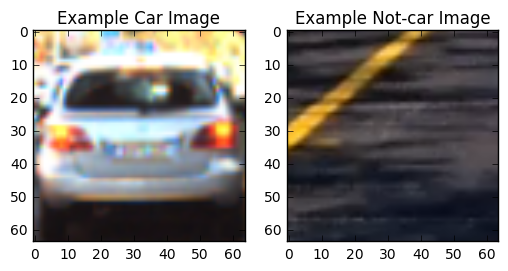

In [49]:
# Import all image paths for the images used to train the classifier
car_paths = glob.glob('dataset_vehicles/*/*.png')
not_car_paths = glob.glob('dataset_non_vehicles/*/*.png')
print('Number of car images: ', len(car_paths))
print('Number of not-car images: ', len(not_car_paths))
example_image = mpimg.imread(car_paths[0])
print('Image shape: ', example_image.shape)
print('Image data type: ', type(example_image), ", ", example_image.dtype)

# Import all image paths for the images to test your classifier on
test_paths = glob.glob('test_images/*.jpg')

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(car_paths))
notcar_ind = np.random.randint(0, len(not_car_paths))
    
# Read in car / not-car images
car_image = mpimg.imread(car_paths[car_ind])
notcar_image = mpimg.imread(not_car_paths[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

## Feature Extraction: Perform a Histogram of Oriented Gradients (HOG)

* Implement helper functions to extract HOG features from images
* Test it on example images

In [5]:
# Function returns HOG features and visualization
# orient: Number of orientation bins
# pix_per_cell: (2-tuple, (int, int)). Size of a cell (in pixels).
# cell_per_block: (2-tuple, (int, int)). Number of cells in each block.
# vis: bool. Return an image of the HOG?
# feature_vec: bool. Return the data as a feature vector by calling .ravel() on it?

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient,
                        pixels_per_cell=(pix_per_cell, pix_per_cell),
                        cells_per_block=(cell_per_block, cell_per_block),
                        visualise=vis, feature_vector=feature_vec)
        return features

Write some text here

(64, 64)


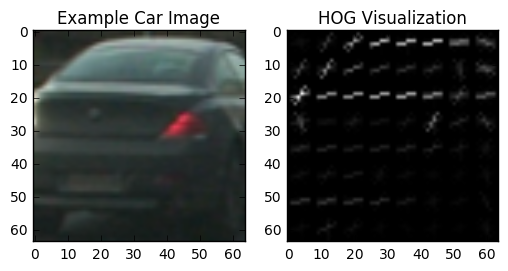

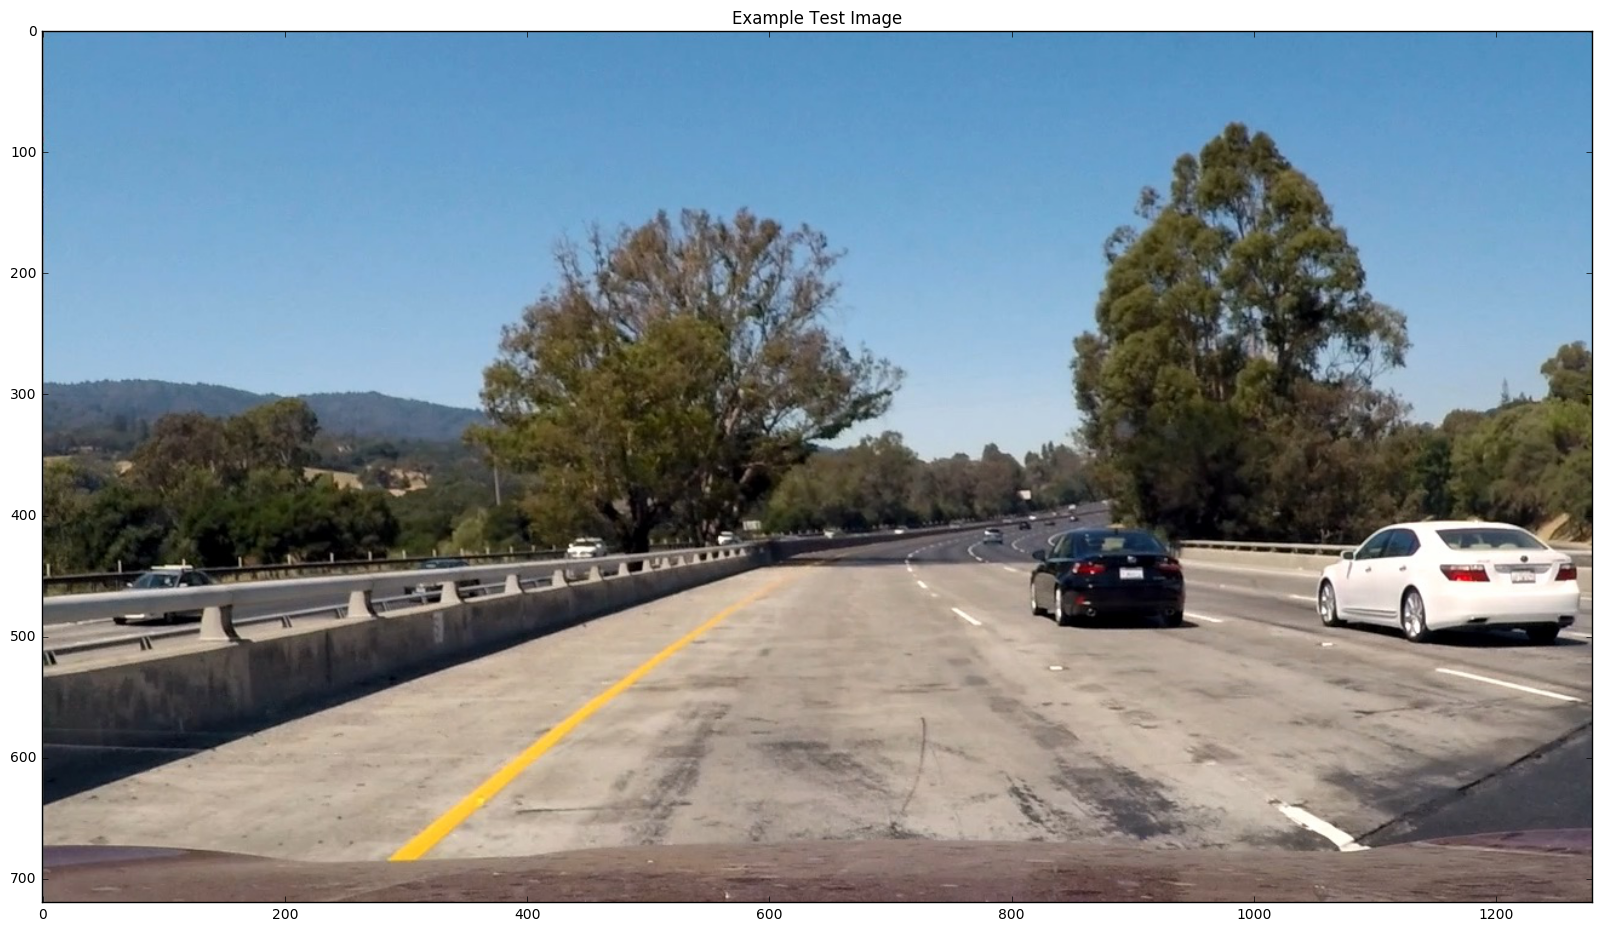

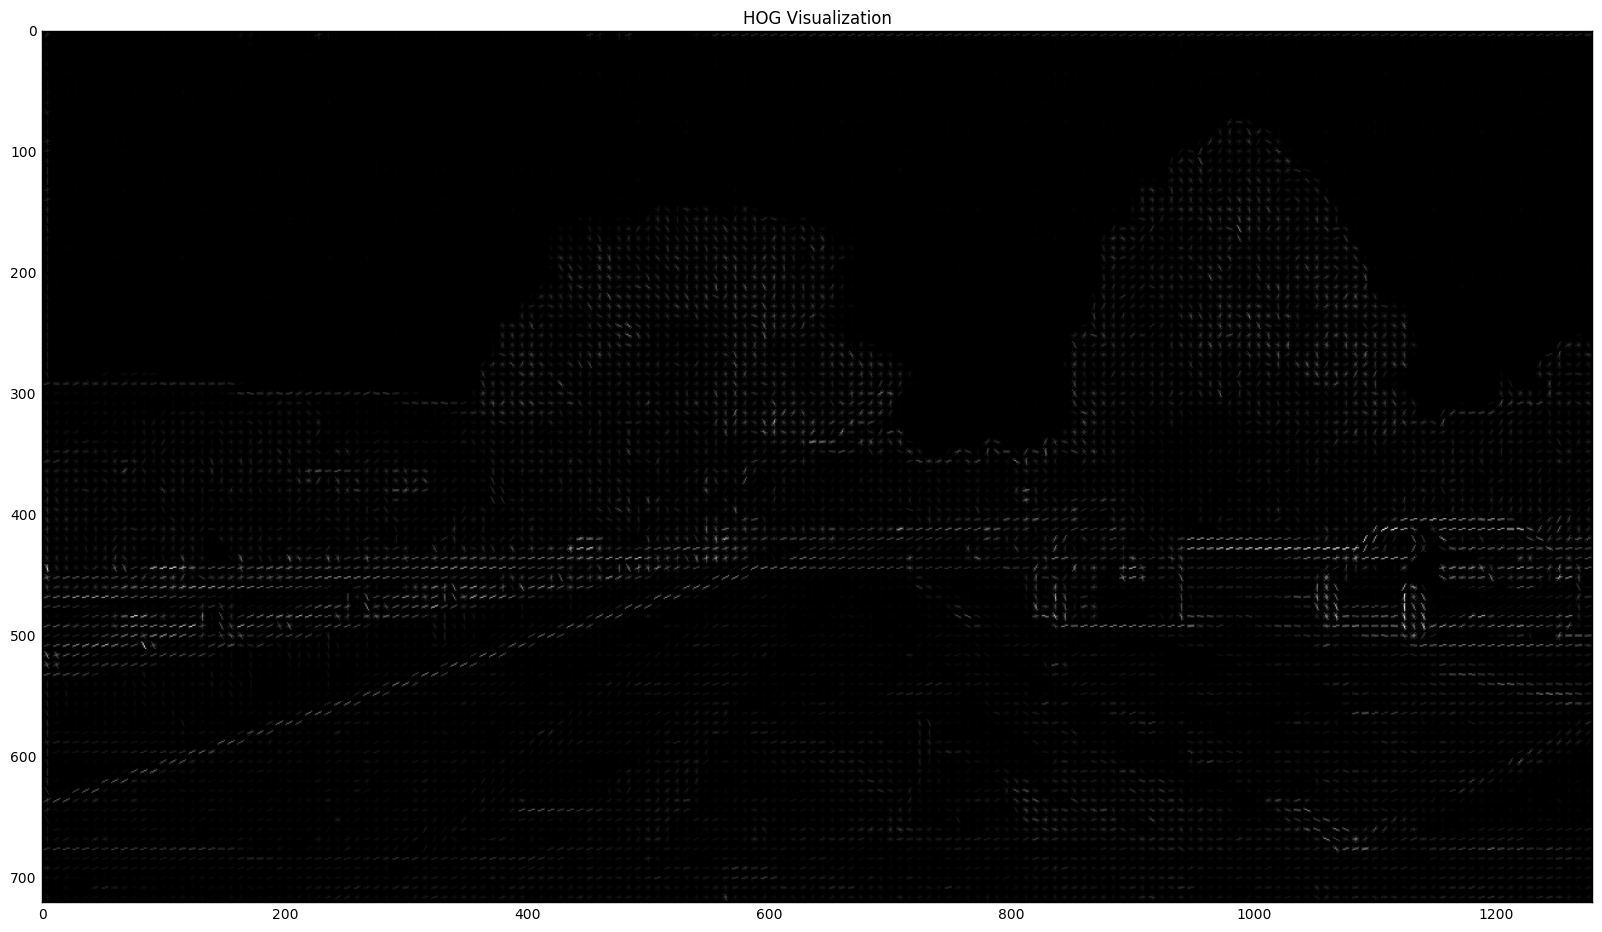

In [6]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(car_paths))
# Read in the image. Let's work with values between 0 to 255
image = mpimg.imread(car_paths[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
print(gray.shape)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Get the HOG features and visualization
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, 
                                       vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

# Test it on a test image
image = mpimg.imread(test_paths[0])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Get the HOG features and visualization
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, 
                                       vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(figsize = (20, 20))
plt.imshow(image)
plt.title('Example Test Image')
fig = plt.figure(figsize = (20, 20))
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

If you look closely, you can recognize the cars in the HOG visualization! :D

## Feature Extraction: other color spaces

* Let's see how HOG works for other color spaces than RGB (e.g. HSV, LUV, HLS, YUV, YCrCb)
* To do that, let's define a new function

In [22]:
# Define a function to extract features from a list of images
# Have this function call get_hog_features()
def extract_features(img_files, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in img_files:
        # Read in each one by one
        img = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            else:
                print('Given image space is not defined.')
        else: 
            img = np.uint8(img*255)
            feature_image = np.copy(img)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

There are a lot of parameters to tweak to see which ones result in the best accuracy. Optimally, we'd like to plot the training accuracy vs. test accuracy - but let's just look at the test accuracy here.

Let's do a grid search over: 
* all color spaces: RGB, HSV, LUV, YUV, YCrCb
* orientations: 9, 12
* pix_per_cell: 4, 8, 16
* cell_per_block: 2, 4

Let's not change these parameters:
* hog_channel = "ALL"

Kedar: 16 pixels per cell, YUV color space, 4 cells per block, .5 overlap, HOG on all 3 channels

But first, let's make sure that the training and validation set are truly different, so let's split them before shuffling.

In [53]:
# Split the data before shuffling it, that'll help to avoid overfitting
# Explanation: If you shuffle before splitting the dataset into training & validation sets,
# you will have very similar data in both sets, which will set you up for overfitting.
print('len(car_paths): ', len(car_paths))
print('len(not_car_paths): ', len(not_car_paths))

num_val_set = int(len(car_paths) * 0.2)
num_train_set = int(len(car_paths) - num_val_set)
print("num_val_set: ", num_val_set)
print("num_train_set: ", num_train_set)

# Take the same number of car and not-car images. Separate
# training and validation set.
train_set_cars = car_paths[:num_train_set]
train_set_not_cars = not_car_paths[:num_train_set]
val_set_cars = car_paths[num_train_set:]
val_set_not_cars = not_car_paths[num_train_set:]

len(car_paths):  8792
len(not_car_paths):  8968
num_val_set:  1758
num_train_set:  7034


In [54]:
# Apply the HOG feature extraction to the data
# Let's do a grid search on the parameters:

# Reduce the sample size because HOG features are slow to compute
# Which is not good for grid search!
sample_size = 500
test_size = int(sample_size*0.2)

# Shuffle training set
train_set_cars_grid = shuffle(train_set_cars)
train_set_not_cars_grid = shuffle(train_set_not_cars)
val_set_cars_grid = shuffle(val_set_cars)
val_set_not_cars_grid = shuffle(val_set_not_cars)

# Reduce the size of the dataset for the grid search
train_set_cars_grid = train_set_cars_grid[:sample_size]
train_set_not_cars_grid = train_set_not_cars_grid[:sample_size]
val_set_cars_grid = val_set_cars_grid[:test_size]
val_set_not_cars_grid = val_set_not_cars_grid[:test_size]

# colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9
# pix_per_cell = 8
# cell_per_block = 2
# hog_channel can be 0, 1, 2, or "ALL" meaning that you extract HOG features
# from the first, second, third or all color channels, respectively
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

for colorspace in ['RGB', 'HSV', 'LUV', 'YUV', 'YCrCb']:
    for orient in [9, 12]:
        for pix_per_cell in [4, 8, 16]:
            for cell_per_block in [2, 4]:

                # Extract features from images with and without cars.
                car_features_train = extract_features(train_set_cars_grid, 
                                                      cspace=colorspace, orient=orient, 
                                                      pix_per_cell=pix_per_cell, 
                                                      cell_per_block=cell_per_block, 
                                                      hog_channel=hog_channel)
                notcar_features_train = extract_features(train_set_not_cars_grid, 
                                                         cspace=colorspace, orient=orient, 
                                                         pix_per_cell=pix_per_cell, 
                                                         cell_per_block=cell_per_block, 
                                                         hog_channel=hog_channel)
                car_features_val = extract_features(val_set_cars_grid, cspace=colorspace, 
                                                    orient=orient, 
                                                    pix_per_cell=pix_per_cell, 
                                                    cell_per_block=cell_per_block, 
                                                    hog_channel=hog_channel)
                notcar_features_val = extract_features(val_set_not_cars_grid, 
                                                       cspace=colorspace, orient=orient, 
                                                       pix_per_cell=pix_per_cell, 
                                                       cell_per_block=cell_per_block, 
                                                       hog_channel=hog_channel)
                
                # Create an array stack of feature vectors
                X_train = np.vstack((car_features_train, 
                                     notcar_features_train)).astype(np.float64)
                X_val = np.vstack((car_features_val, notcar_features_val)).astype(np.float64)

                # Fit a per-column scaler
                X_scaler = StandardScaler().fit(X_train)
                # Apply the scaler to X_train and X_val
                scaled_X_train = X_scaler.transform(X_train)
                scaled_X_val = X_scaler.transform(X_val)

                # Define the labels vector
                y_train = np.hstack((np.ones(len(car_features_train)), 
                                     np.zeros(len(notcar_features_train))))
                y_val = np.hstack((np.ones(len(car_features_val)), 
                                   np.zeros(len(notcar_features_val))))

                print('Using:',orient,'orientations',pix_per_cell,
                    'pixels per cell and', cell_per_block,'cells per block')
                print('Feature vector length:', len(X_train[0]))
                # Use a linear SVC 
                svc = LinearSVC()
                # Check the training time for the SVC
                t=time.time()
                svc.fit(X_train, y_train)
                t2 = time.time()
                print(round(t2-t, 2), 'Seconds to train SVC...')
                # Check the score of the SVC
                print('Test Accuracy of SVC = ', round(svc.score(X_val, y_val), 4))
                # Check the prediction time for a single sample
                t=time.time()
                n_predict = 10
                print('My SVC predicts: ', svc.predict(X_val[0:n_predict]))
                print('For these',n_predict, 'labels: ', y_val[0:n_predict])
                t2 = time.time()
                print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
                print()

Using: 9 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 24300
15.39 Seconds to train SVC...
Test Accuracy of SVC =  0.97
My SVC predicts:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
0.00489 Seconds to predict 10 labels with SVC

Using: 9 orientations 4 pixels per cell and 4 cells per block
Feature vector length: 73008
9.48 Seconds to train SVC...
Test Accuracy of SVC =  0.97
My SVC predicts:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
0.00528 Seconds to predict 10 labels with SVC

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
1.17 Seconds to train SVC...
Test Accuracy of SVC =  0.955
My SVC predicts:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
0.00242 Seconds to predict 10 labels with SVC

Using: 9 orientations 8 pixels per cell

### Let's try the 'best' parameter combinations and let's train the model properly.

What I found to be the 'best' parameter combination in my grid search could be those three:

* HSV, orient: 12, pix_per_cell: 4, cell_per_block: 4 (97344 features)
* YUV, orient: 12, pix_per_cell: 4, cell_per_block: 4 (97344 features)
* YCrCb, orient: 12, pix_per_cell: 8, cell_per_block: 2 (47056 features)

### Try LUV

In [60]:
# Apply the HOG feature extraction to the data
colorspace = 'LUV'
orient = 12
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL"

# Extract features from images with and without cars.
car_features_train = extract_features(train_set_cars, cspace=colorspace, orient=orient, 
                                      pix_per_cell=pix_per_cell, 
                                      cell_per_block=cell_per_block, 
                                      hog_channel=hog_channel)
print('done with calculating car-train features')
notcar_features_train = extract_features(train_set_not_cars, cspace=colorspace, orient=orient, 
                                         pix_per_cell=pix_per_cell, 
                                         cell_per_block=cell_per_block, 
                                         hog_channel=hog_channel)
print('done with calculating notcar-train features')
car_features_val = extract_features(val_set_cars, cspace=colorspace, orient=orient, 
                                    pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel)
print('done with calculating car-val features')
notcar_features_val = extract_features(val_set_not_cars, cspace=colorspace, orient=orient, 
                                       pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel)
print('done with calculating notcar-val features')

done with calculating car-train features
done with calculating notcar-train features
done with calculating car-val features
done with calculating notcar-val features


In [61]:
print('len(car_features_train): ', len(car_features_train))
print('len(notcar_features_train): ', len(notcar_features_train))
print('len(car_features_val): ', len(car_features_val))
print('len(notcar_features_val): ', len(notcar_features_val))

# Create an array stack of feature vectors
X_train = np.vstack((car_features_train, notcar_features_train)).astype(np.float64)
X_val = np.vstack((car_features_val, notcar_features_val)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_val
scaled_X_train = X_scaler.transform(X_train)
scaled_X_val = X_scaler.transform(X_val)
print('done transforming data')

# Define the labels vector
y_train = np.hstack((np.ones(len(car_features_train)), np.zeros(len(notcar_features_train))))
y_val = np.hstack((np.ones(len(car_features_val)), np.zeros(len(notcar_features_val))))
print('done preparing label vector')

len(car_features_train):  7034
len(notcar_features_train):  7034
len(car_features_val):  1758
len(notcar_features_val):  1934
done transforming data
done preparing label vector


In [57]:
# Shuffle the data
X_train_shuffled, y_train_shuffled = shuffle(scaled_X_train, y_train)
X_val_shuffled, y_val_shuffled = shuffle(scaled_X_val, y_val)
print('done splitting data')
print(X_train_shuffled.size)
print(y_train_shuffled.size)
print(X_val_shuffled.size)
print(y_val_shuffled.size)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train_shuffled[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train_shuffled, y_train_shuffled)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

done splitting data
99263808
14068
26050752
3692
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7056
49.98 Seconds to train SVC...


In [47]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_val_shuffled, y_val_shuffled), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_val_shuffled[0:n_predict]))
print('For these',n_predict, 'labels: ', y_val_shuffled[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
print()

Test Accuracy of SVC =  0.9347
My SVC predicts:  [ 0.  1.  0.  1.  1.  0.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  1.  1.  0.  1.  1.  0.  0.]
0.01239 Seconds to predict 10 labels with SVC



### Try YCrCb

In [62]:
# YCrCb, orient: 12, pix_per_cell: 8, cell_per_block: 2 (47056 features)
colorspace = 'YCrCb'
orient = 12
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL"

# Extract features from images with and without cars.
car_features_train = extract_features(train_set_cars, cspace=colorspace, orient=orient, 
                                      pix_per_cell=pix_per_cell, 
                                      cell_per_block=cell_per_block, 
                                      hog_channel=hog_channel)
print('done with calculating car-train features')
notcar_features_train = extract_features(train_set_not_cars, cspace=colorspace, orient=orient, 
                                         pix_per_cell=pix_per_cell, 
                                         cell_per_block=cell_per_block, 
                                         hog_channel=hog_channel)
print('done with calculating notcar-train features')
car_features_val = extract_features(val_set_cars, cspace=colorspace, orient=orient, 
                                    pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel)
print('done with calculating car-val features')
notcar_features_val = extract_features(val_set_not_cars, cspace=colorspace, orient=orient, 
                                       pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel)
print('done with calculating notcar-val features')

print('len(car_features_train): ', len(car_features_train))
print('len(notcar_features_train): ', len(notcar_features_train))
print('len(car_features_val): ', len(car_features_val))
print('len(notcar_features_val): ', len(notcar_features_val))

# Create an array stack of feature vectors
X_train = np.vstack((car_features_train, notcar_features_train)).astype(np.float64)
X_val = np.vstack((car_features_val, notcar_features_val)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_val
scaled_X_train = X_scaler.transform(X_train)
scaled_X_val = X_scaler.transform(X_val)
print('done transforming data')

# Define the labels vector
y_train = np.hstack((np.ones(len(car_features_train)), np.zeros(len(notcar_features_train))))
y_val = np.hstack((np.ones(len(car_features_val)), np.zeros(len(notcar_features_val))))
print('done preparing label vector')

# Shuffle the data
X_train_shuffled, y_train_shuffled = shuffle(scaled_X_train, y_train)
X_val_shuffled, y_val_shuffled = shuffle(scaled_X_val, y_val)
print('done splitting data')
print(X_train_shuffled.size)
print(y_train_shuffled.size)
print(X_val_shuffled.size)
print(y_val_shuffled.size)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train_shuffled[0]))
# Use a linear SVC 
svc2 = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc2.fit(X_train_shuffled, y_train_shuffled)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc2.score(X_val_shuffled, y_val_shuffled), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc2.predict(X_val_shuffled[0:n_predict]))
print('For these',n_predict, 'labels: ', y_val_shuffled[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
print()

done with calculating car-train features
done with calculating notcar-train features
done with calculating car-val features
done with calculating notcar-val features
len(car_features_train):  7034
len(notcar_features_train):  7034
len(car_features_val):  1758
len(notcar_features_val):  1934
done transforming data
done preparing label vector
done splitting data
99263808
14068
26050752
3692
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7056
32.32 Seconds to train SVC...
Test Accuracy of SVC =  0.9426
My SVC predicts:  [ 0.  1.  0.  1.  0.  0.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  0.  0.  0.  1.  0.  0.]
0.03306 Seconds to predict 10 labels with SVC



### Try HSV!

In [40]:
print(len(scaled_X_train))
print(len(y_train))
print(len(scaled_X_val))
print(len(y_val))

1000
1000
200
200


In [63]:
# HSV, orient: 12, pix_per_cell: 4, cell_per_block: 4 (97344 features)
colorspace = 'HSV'
orient = 12
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL"
# Shuffle the data
# X_train_shuffled, y_train_shuffled = shuffle(scaled_X_train, y_train)
# X_val_shuffled, y_val_shuffled = shuffle(scaled_X_val, y_val)

# Extract features from images with and without cars.
car_features_train = extract_features(train_set_cars, cspace=colorspace, orient=orient, 
                                      pix_per_cell=pix_per_cell, 
                                      cell_per_block=cell_per_block, 
                                      hog_channel=hog_channel)
print('done with calculating car-train features')
notcar_features_train = extract_features(train_set_not_cars, cspace=colorspace, orient=orient, 
                                         pix_per_cell=pix_per_cell, 
                                         cell_per_block=cell_per_block, 
                                         hog_channel=hog_channel)
print('done with calculating notcar-train features')
car_features_val = extract_features(val_set_cars, cspace=colorspace, orient=orient, 
                                    pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel)
print('done with calculating car-val features')
notcar_features_val = extract_features(val_set_not_cars, cspace=colorspace, orient=orient, 
                                       pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel)
print('done with calculating notcar-val features')

print('len(car_features_train): ', len(car_features_train))
print('len(notcar_features_train): ', len(notcar_features_train))
print('len(car_features_val): ', len(car_features_val))
print('len(notcar_features_val): ', len(notcar_features_val))

# Create an array stack of feature vectors
X_train = np.vstack((car_features_train, notcar_features_train)).astype(np.float64)
X_val = np.vstack((car_features_val, notcar_features_val)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
print('done fitting the Scaler')
# Apply the scaler to X_train and X_val
scaled_X_train = X_scaler.transform(X_train)
scaled_X_val = X_scaler.transform(X_val)
print('done transforming data')

# Define the labels vector
y_train = np.hstack((np.ones(len(car_features_train)), np.zeros(len(notcar_features_train))))
y_val = np.hstack((np.ones(len(car_features_val)), np.zeros(len(notcar_features_val))))
print('done preparing label vector')

# Shuffle the data
X_train_shuffled, y_train_shuffled = shuffle(scaled_X_train, y_train)
X_val_shuffled, y_val_shuffled = shuffle(scaled_X_val, y_val)
print('done splitting data')
print(X_train_shuffled.size)
print(y_train_shuffled.size)
print(X_val_shuffled.size)
print(y_val_shuffled.size)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train_shuffled[0]))
# Use a linear SVC 
svc3 = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc3.fit(X_train_shuffled, y_train_shuffled)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc3.score(X_val_shuffled, y_val_shuffled), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc3.predict(X_val_shuffled[0:n_predict]))
print('For these',n_predict, 'labels: ', y_val_shuffled[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
print()

done with calculating car-train features
done with calculating notcar-train features
done with calculating car-val features
done with calculating notcar-val features
len(car_features_train):  7034
len(notcar_features_train):  7034
len(car_features_val):  1758
len(notcar_features_val):  1934
done fitting the Scaler
done transforming data
done preparing label vector
done splitting data
99263808
14068
26050752
3692
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7056
47.46 Seconds to train SVC...
Test Accuracy of SVC =  0.9507
My SVC predicts:  [ 1.  0.  1.  1.  1.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  0.  0.  0.  0.  1.]
0.02783 Seconds to predict 10 labels with SVC



## Train a linear Support Vector Machine (SVM) classifier

* Train a classifier to detect cars

### Let's try one more time, the winner of my grid search: HSV (9, 4, 2) and RGB (9, 4, 2)

In [64]:
# HSV, orient: 12, pix_per_cell: 4, cell_per_block: 4 (97344 features)
colorspace = 'HSV'
orient = 9
pix_per_cell = 4
cell_per_block = 2
hog_channel = "ALL"
# Shuffle the data
# X_train_shuffled, y_train_shuffled = shuffle(scaled_X_train, y_train)
# X_val_shuffled, y_val_shuffled = shuffle(scaled_X_val, y_val)

# Extract features from images with and without cars.
car_features_train = extract_features(train_set_cars, cspace=colorspace, orient=orient, 
                                      pix_per_cell=pix_per_cell, 
                                      cell_per_block=cell_per_block, 
                                      hog_channel=hog_channel)
print('done with calculating car-train features')
notcar_features_train = extract_features(train_set_not_cars, cspace=colorspace, orient=orient, 
                                         pix_per_cell=pix_per_cell, 
                                         cell_per_block=cell_per_block, 
                                         hog_channel=hog_channel)
print('done with calculating notcar-train features')
car_features_val = extract_features(val_set_cars, cspace=colorspace, orient=orient, 
                                    pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel)
print('done with calculating car-val features')
notcar_features_val = extract_features(val_set_not_cars, cspace=colorspace, orient=orient, 
                                       pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel)
print('done with calculating notcar-val features')

print('len(car_features_train): ', len(car_features_train))
print('len(notcar_features_train): ', len(notcar_features_train))
print('len(car_features_val): ', len(car_features_val))
print('len(notcar_features_val): ', len(notcar_features_val))

# Create an array stack of feature vectors
X_train = np.vstack((car_features_train, notcar_features_train)).astype(np.float64)
X_val = np.vstack((car_features_val, notcar_features_val)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
print('done fitting the Scaler')
# Apply the scaler to X_train and X_val
scaled_X_train = X_scaler.transform(X_train)
scaled_X_val = X_scaler.transform(X_val)
print('done transforming data')

# Define the labels vector
y_train = np.hstack((np.ones(len(car_features_train)), np.zeros(len(notcar_features_train))))
y_val = np.hstack((np.ones(len(car_features_val)), np.zeros(len(notcar_features_val))))
print('done preparing label vector')

# Shuffle the data
X_train_shuffled, y_train_shuffled = shuffle(scaled_X_train, y_train)
X_val_shuffled, y_val_shuffled = shuffle(scaled_X_val, y_val)
print('done splitting data')
print(X_train_shuffled.size)
print(y_train_shuffled.size)
print(X_val_shuffled.size)
print(y_val_shuffled.size)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train_shuffled[0]))
# Use a linear SVC 
svc3 = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc3.fit(X_train_shuffled, y_train_shuffled)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc3.score(X_val_shuffled, y_val_shuffled), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc3.predict(X_val_shuffled[0:n_predict]))
print('For these',n_predict, 'labels: ', y_val_shuffled[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
print()

done with calculating car-train features
done with calculating notcar-train features
done with calculating car-val features
done with calculating notcar-val features
len(car_features_train):  7034
len(notcar_features_train):  7034
len(car_features_val):  1758
len(notcar_features_val):  1934
done fitting the Scaler
done transforming data
done preparing label vector
done splitting data
341852400
14068
89715600
3692
Using: 9 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 24300
401.69 Seconds to train SVC...
Test Accuracy of SVC =  0.9537
My SVC predicts:  [ 1.  1.  0.  0.  0.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  0.  1.  1.  0.  1.]
0.06144 Seconds to predict 10 labels with SVC



## Sliding Window Search

* Implement a sliding-window technique and use your trained classifier to search for vehicles in images

In [131]:
# Function that draws boxes onto image, based on a list of boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    else:
        print('you have to specify a known conversion')
        return None

# find_cars is able to both extract features & make predictions
# find_cars only has to extract hog features once and then can be 
# sub-sampled to get all of its overlaying windows

# Define a single function that can extract features using hog 
# sub-sampling and make predictions
def find_cars(img, ystart, ystop, scales, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block):
    
    box_list = []
    draw_img = np.copy(img)
    # NOTE: If you read in jpg with mpimg, you'll get 0-255 images. 
    # If you read in png, you get 0-1
    # This function wants 0-1, so downscale images with numbers 0-255
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2HSV')
    for scale in scales:
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, 
                                         (np.int(imshape[1]/scale), 
                                          np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell)-1
        nyblocks = (ch1.shape[0] // pix_per_cell)-1 
        nfeat_per_block = orient*cell_per_block**2
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell)-1 
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, 
                                feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, 
                                feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, 
                                feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, 
                                 xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, 
                                 xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, 
                                 xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, 
                                                    xleft:xleft+window], 
                                    (64,64))

                # Scale features and make a prediction
                test_features = X_scaler.transform((hog_features).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                # if True:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    box_list.append(((xbox_left, ytop_draw+ystart),
                                     (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                    
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                                  (xbox_left+win_draw,ytop_draw+win_draw+ystart),
                                  (0,0,255),6) 
                
    return box_list, draw_img

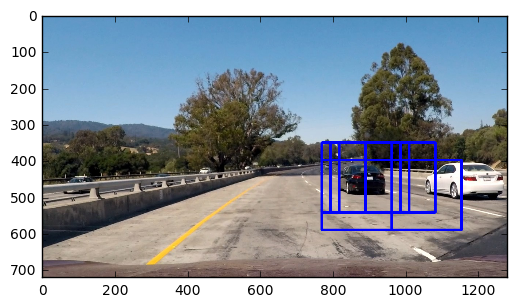

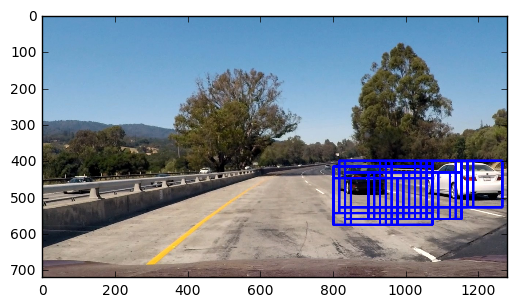

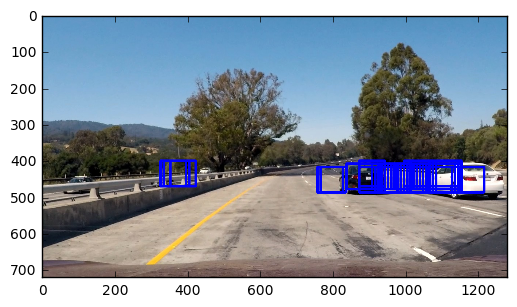

In [134]:
colorspace = 'HSV'
orient = 9
pix_per_cell = 4
cell_per_block = 2

ystart = [350, 400, 400]

box_list = []

ystart = 350
ystop = 656
scales = [3]

test_files = glob.glob('test_images/test*.jpg')
test_image = mpimg.imread(test_files[0])

# Let's create a searching method that best scans the desired region
boxes, out_img = find_cars(test_image, ystart, ystop, scales, 
                              svc3, X_scaler, orient, pix_per_cell, 
                              cell_per_block)

box_list.extend(boxes)
plt.imshow(out_img)
plt.show()


ystart = 400
ystop = 600
scales = [2]

test_files = glob.glob('test_images/test*.jpg')
test_image = mpimg.imread(test_files[0])

# Let's create a searching method that best scans the desired region
boxes, out_img = find_cars(test_image, ystart, ystop, scales, svc3, X_scaler, 
                    orient, pix_per_cell, cell_per_block)

box_list.extend(boxes)
plt.imshow(out_img)
plt.show()

ystart = 400
ystop = 500
scales = [1.1]

test_files = glob.glob('test_images/test*.jpg')
test_image = mpimg.imread(test_files[0])

# Let's create a searching method that best scans the desired region
boxes, out_img = find_cars(test_image, ystart, ystop, scales, svc3, X_scaler, 
                    orient, pix_per_cell, cell_per_block)

box_list.extend(boxes)
plt.imshow(out_img)
plt.show()

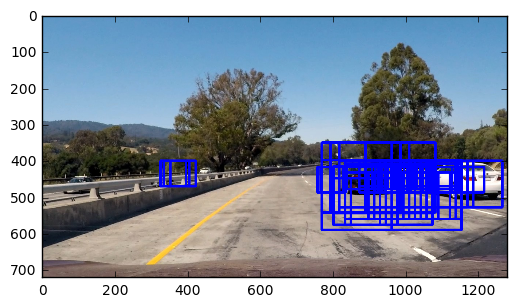

In [136]:
boxes_image = mpimg.imread(test_files[0])
for box in box_list:
    cv2.rectangle(boxes_image,box[0], box[1], (0,0,255),6) 
plt.imshow(boxes_image)
plt.show()

In [140]:
heat_image = mpimg.imread(test_files[0])
heat = np.zeros_like(heat_image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(heat_image), labels)

In [ ]:
for file in test_files:
    test_image = mpimg.imread(file)

    out_img = find_cars(test_image, ystart, ystop, scales, svc3, X_scaler, 
                        orient, pix_per_cell, cell_per_block)
    

    plt.imshow(out_img)
    plt.show()

## Apply pipeline on a video stream

* Run your pipeline on a video stream
* Create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.